In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cup-it-2023/all_features_final_val.csv
/kaggle/input/cup-it-2023/owner_target_final.csv
/kaggle/input/cup-it-2023/feat_cup.csv
/kaggle/input/cup-it-2023/all_features_final.csv


In [3]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import shap

In [22]:
feat_cup = pd.read_csv('/kaggle/input/cup-it-2023/all_features_final.csv', sep=';')
target = pd.read_csv('/kaggle/input/cup-it-2023/owner_target_final.csv')
feat_val = pd.read_csv('/kaggle/input/cup-it-2023/all_features_final_val.csv',sep=';')

In [23]:
feat_cup.shape, target.shape, feat_val.shape

((291882, 407), (8546, 1), (28919, 407))

In [24]:
CAT_FEATURES = [
    'hdb_relend_client_credits_count_grade',
    'age',
    'hdb_bki_total_currency',
    'srvpackage',
    'gender',
    'accountsalary_flag',
    'stratsegfactor',
    'addrref',
    'clientsegment',
    'clientoutflowstatus',
    'country'
]

DROP_COLS = [
    'client_id',
    'dt'
]

In [25]:
def fillna_cat_features(feat_cup, cat_feat):
    for feature in cat_feat:
        feat_cup[feature] = feat_cup[feature].fillna(feat_cup[feature].dropna().mode()[0])
        feat_cup[feature] = feat_cup[feature].apply(lambda x: str(x))
    return feat_cup

In [26]:
def add_target(feat_cup, target):
    feat_cup['target'] = feat_cup['client_id'].apply(lambda x: 1 if x in target['owner_id'].tolist() else 0)
    return feat_cup

In [27]:
feat_cup_target = add_target(feat_cup, target)

In [28]:
feat_cup_prep = fillna_cat_features(feat_cup_target, CAT_FEATURES)

In [13]:
X = feat_cup_prep_sample.drop('target', axis=1).drop(DROP_COLS, axis=1)
y = feat_cup_prep_sample['target']

# Скоринг отложенной выборки

In [29]:
sgkf = StratifiedGroupKFold(n_splits=5)
X['folds'] = np.nan
for fold_num, (train_index, test_index) in enumerate(sgkf.split(X, y, feat_cup_prep_sample['client_id']), 1):
    X.loc[test_index, 'folds'] = f'fold_{fold_num}'

In [30]:
X_train, y_train = X[X['folds'] != 'fold_5'], y[X['folds'] != 'fold_5']
X_test, y_test = X[X['folds'] == 'fold_5'], y[X['folds'] == 'fold_5']

In [34]:
X_val = fillna_cat_features(feat_val, CAT_FEATURES)

In [36]:
X_val = X_val.drop(DROP_COLS, axis=1)

In [39]:
X_train, y_train = X[X['folds'] != 'fold_5'], y[X['folds'] != 'fold_5']
X_test, y_test = X[X['folds'] == 'fold_5'], y[X['folds'] == 'fold_5']

X_train, X_test = X_train.drop('folds', axis=1), X_test.drop('folds', axis=1)

train_pool = Pool(X_train, y_train, cat_features=CAT_FEATURES)
test_pool = Pool(X_test, y_test, cat_features=CAT_FEATURES)

model = CatBoostClassifier(
    eval_metric='AUC',
    cat_features=CAT_FEATURES,
    early_stopping_rounds=20,
    nan_mode='Min'
)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=20, verbose=500)
preds = model.predict_proba(X_val)[:, 1]

Learning rate set to 0.102689
0:	test: 0.8750297	best: 0.8750297 (0)	total: 462ms	remaining: 7m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9303022703
bestIteration = 280

Shrink model to first 281 iterations.


In [43]:
pd.DataFrame({'client_id': feat_val['client_id'], 'score': preds}).to_csv('score_file_final.csv')

# Моделирование

In [24]:
def train_test(X, y, groups):
    sgkf = StratifiedGroupKFold(n_splits=5)
    roc_auc_metrics = []
    predicts = {}
    y_tests = {}
    models = {}
    num_fold = 1
    for (train_index, test_index) in sgkf.split(X, y, groups):
        print(f'FOLD {num_fold}/5')
        train_pool = Pool(X.loc[train_index], y.loc[train_index], cat_features=CAT_FEATURES)
        test_pool = Pool(X.loc[test_index], y.loc[test_index], cat_features=CAT_FEATURES)
    
        model = CatBoostClassifier(
            eval_metric='AUC',
            cat_features=CAT_FEATURES,
            early_stopping_rounds=20,
            nan_mode='Min'
        )
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=20, verbose=500)
        preds = model.predict_proba(test_pool)[:, 1]
        roc_auc_metrics.append(roc_auc_score(y.loc[test_index], preds))
        predicts[num_fold] = preds
        y_tests[num_fold] = y.loc[test_index]
        models[num_fold] = model
        num_fold += 1
        
    return roc_auc_metrics, predicts, y_tests, models

In [25]:
X = feat_cup_prep_sample.drop('target', axis=1).drop(DROP_COLS, axis=1)
y = feat_cup_prep_sample['target']

In [26]:
roc_auc_metrics, predicts, y_tests, models = train_test(X, y, feat_cup_prep_sample['client_id'])

FOLD 1/5
Learning rate set to 0.102689
0:	test: 0.8450495	best: 0.8450495 (0)	total: 398ms	remaining: 6m 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9308431903
bestIteration = 328

Shrink model to first 329 iterations.
FOLD 2/5
Learning rate set to 0.102689
0:	test: 0.8676160	best: 0.8676160 (0)	total: 402ms	remaining: 6m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9291109391
bestIteration = 346

Shrink model to first 347 iterations.
FOLD 3/5
Learning rate set to 0.102689
0:	test: 0.8753179	best: 0.8753179 (0)	total: 390ms	remaining: 6m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9322603928
bestIteration = 194

Shrink model to first 195 iterations.
FOLD 4/5
Learning rate set to 0.102689
0:	test: 0.8592302	best: 0.8592302 (0)	total: 384ms	remaining: 6m 23s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9358327629
bestIteration = 230

Shrink model to first 231 iterations.
FOLD 5/5
Lea

In [28]:
np.mean(roc_auc_metrics)

0.9330198456314346

In [29]:
def plot_roc_curve(y_test, y_pred, label):
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    plt.plot(fpr, tpr, label=label)
    plt.legend()

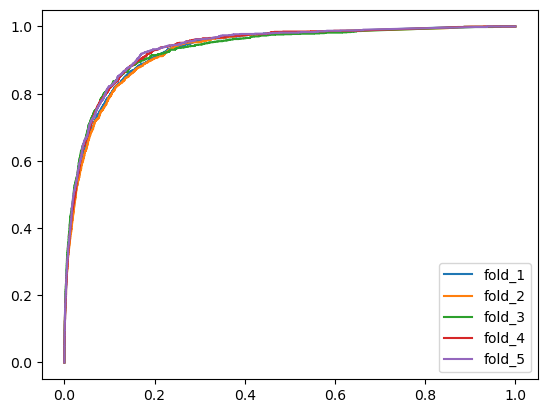

In [30]:
for fold in range(1, 6):
    plot_roc_curve(y_tests[fold],  predicts[fold], label=f'fold_{fold}')

In [31]:
def get_shap_importance(X, y, cat_features, model):
    df_pool = Pool(X, y, cat_features=CAT_FEATURES)
    shap_values = model.get_feature_importance(df_pool, type='ShapValues')
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, X, max_display=30)
    df_shap = pd.DataFrame({'feature': X.columns.tolist(),
                                    'shap': shap_values[0,:]})
    return df_shap

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


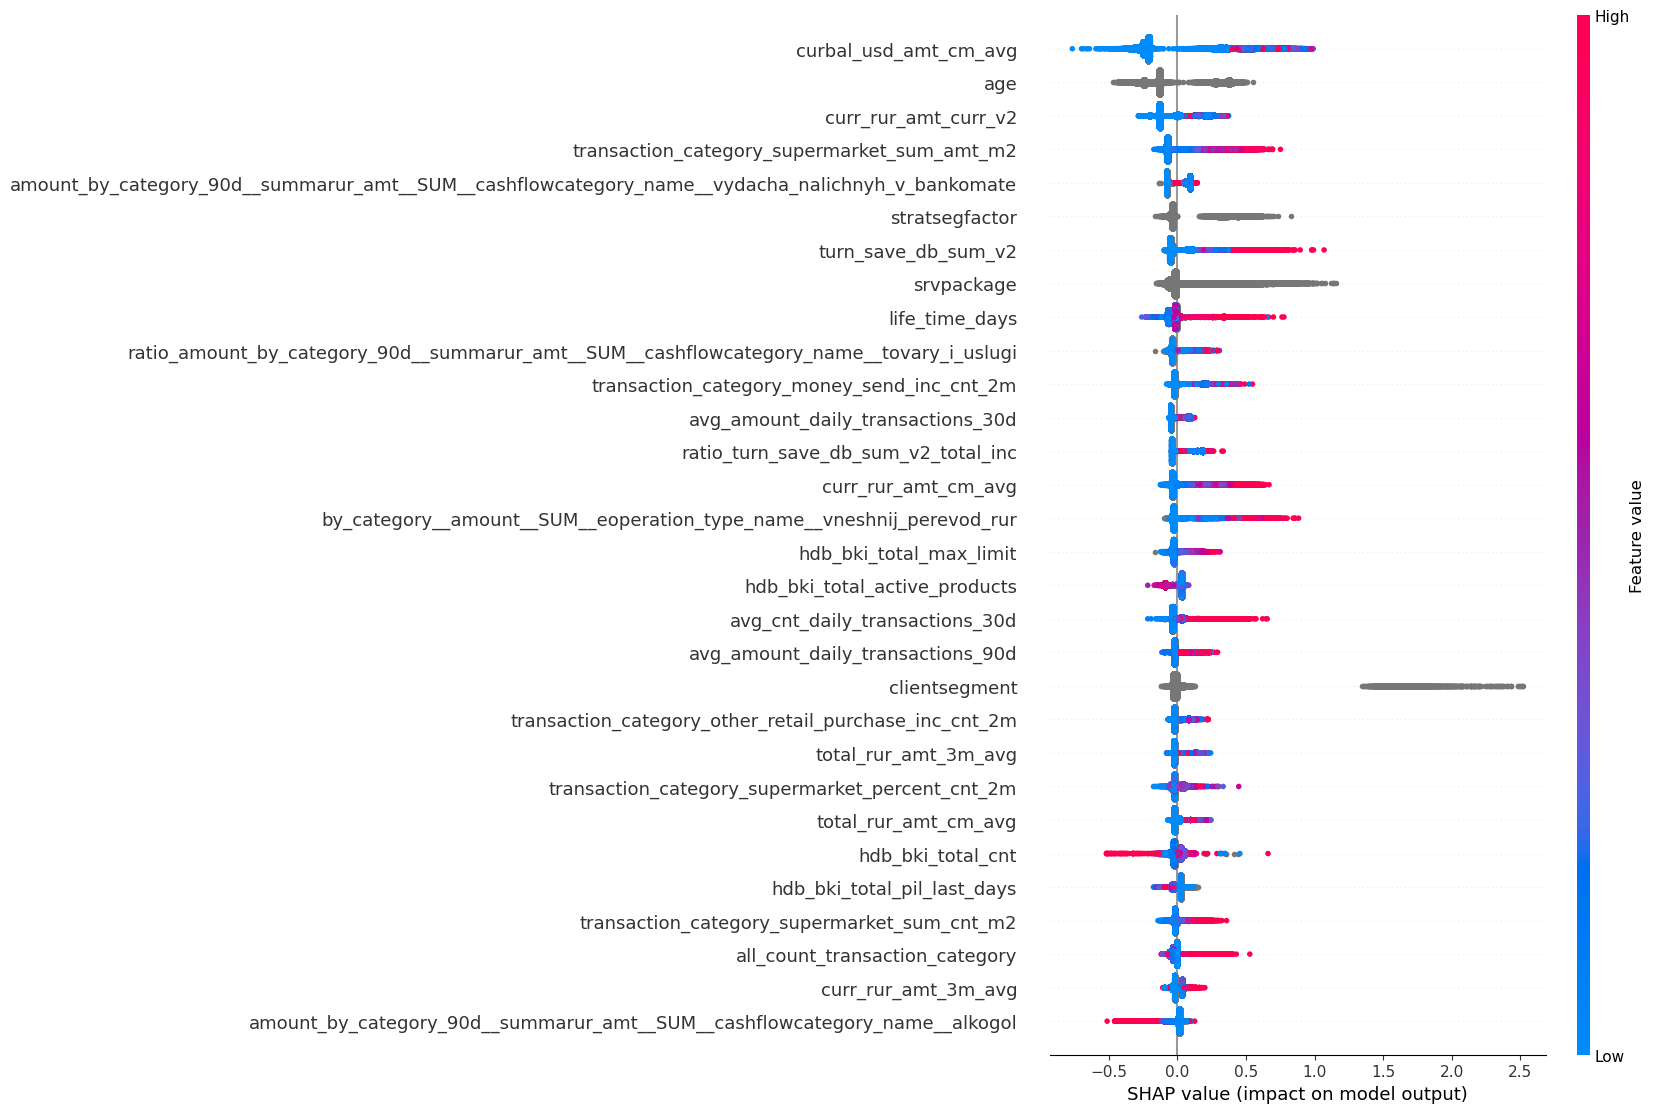

In [32]:
shap_values = get_shap_importance(X, y, CAT_FEATURES, models[1])

In [48]:
shap_values['shap'] = shap_values['shap'].apply(lambda x: abs(x))

In [54]:
FILTER_FEATURES_SHAP = shap_values[shap_values['shap'] > 0.005]['feature'].tolist()

In [55]:
len(FILTER_FEATURES_SHAP)

100

In [56]:
sorted_features_shap = shap_values[shap_values['shap'] > 0.005].sort_values(by='shap', ascending=False)['feature'].tolist()

In [57]:
len(sorted_features_shap)

100